In [ ]:
#Import the necessary libraries and load the dataset
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


11490434/11490434 [==============================] - 2s 0us/step


In [ ]:
#Define the generator model
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

generator = make_generator_model()

In [ ]:
#Define the discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))

    return model

discriminator = make_discriminator_model()

In [ ]:
#Define the loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


In [ ]:
# Define optimizers for generator and discriminator
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
# Define batch size and number of epochs
batch_size = 256
epochs = 100  #reduced from 100 to 10 so that it runs faster

# Define random seed for reproducibility
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
EPOCHS = 100 #reduced from 100 to 10 so that it runs faster
noise_dim = 100
num_examples_to_generate = 16

# We'll re-use this random vector used to visualize progress during training
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Define training step
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def generate_and_save_images(model, epoch, test_input):
    # Generate images from the model
    predictions = model(test_input, training=False)
    # Rescale the images from [-1, 1] to [0, 1]
    predictions = (predictions + 1) / 2.0

    # Plot the generated images in a grid
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 0.5 + 0.5, cmap='gray')
        plt.axis('off')

    # Save the figure
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [ ]:
# def train(dataset, epochs):
#     for epoch in range(epochs):
#         for image_batch in dataset:
#             train_step(image_batch)

#         # Visualize the progress
#         if epoch % 10 == 0:
#             generate_and_save_images(generator, epoch, seed)

#         print('Epoch {} complete'.format(epoch + 1))

#     # Generate a final image and save it
#     generate_and_save_images(generator, epochs, seed)

# train(train_dataset, EPOCHS)

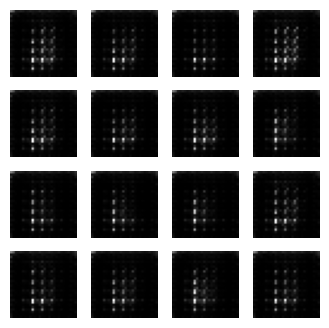

Epoch 1, Generator Loss: 0.5032, Discriminator Loss: 1.4960, Real Accuracy: 0.7336, Fake Accuracy: 0.5011
Epoch 2 complete
Epoch 3 complete
Epoch 4 complete
Epoch 5 complete
Epoch 6 complete
Epoch 7 complete
Epoch 8 complete
Epoch 9 complete
Epoch 10 complete


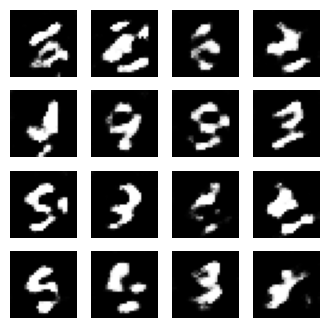

Epoch 11, Generator Loss: 0.9700, Discriminator Loss: 1.1598, Real Accuracy: 0.4364, Fake Accuracy: 0.9370
Epoch 12 complete
Epoch 13 complete
Epoch 14 complete
Epoch 15 complete
Epoch 16 complete
Epoch 17 complete
Epoch 18 complete
Epoch 19 complete
Epoch 20 complete


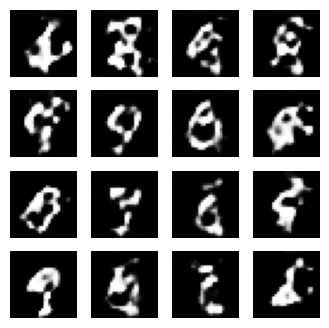

Epoch 21, Generator Loss: 1.2274, Discriminator Loss: 0.9447, Real Accuracy: 0.5834, Fake Accuracy: 0.9517
Epoch 22 complete
Epoch 23 complete
Epoch 24 complete
Epoch 25 complete
Epoch 26 complete
Epoch 27 complete
Epoch 28 complete
Epoch 29 complete
Epoch 30 complete


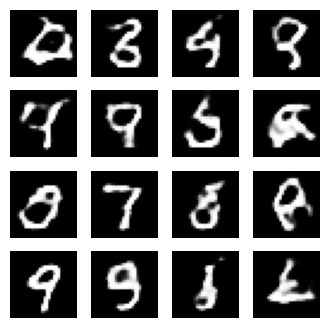

Epoch 31, Generator Loss: 1.0377, Discriminator Loss: 1.0910, Real Accuracy: 0.4418, Fake Accuracy: 0.9462
Epoch 32 complete
Epoch 33 complete
Epoch 34 complete
Epoch 35 complete
Epoch 36 complete
Epoch 37 complete
Epoch 38 complete
Epoch 39 complete
Epoch 40 complete


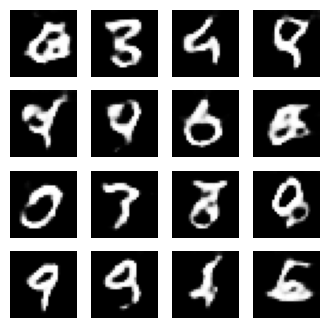

Epoch 41, Generator Loss: 0.9966, Discriminator Loss: 1.1412, Real Accuracy: 0.4599, Fake Accuracy: 0.9206
Epoch 42 complete
Epoch 43 complete
Epoch 44 complete
Epoch 45 complete
Epoch 46 complete
Epoch 47 complete
Epoch 48 complete
Epoch 49 complete
Epoch 50 complete


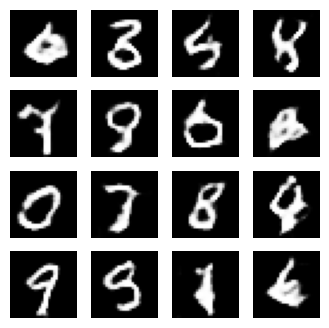

Epoch 51, Generator Loss: 0.9889, Discriminator Loss: 1.1411, Real Accuracy: 0.4620, Fake Accuracy: 0.9249
Epoch 52 complete
Epoch 53 complete
Epoch 54 complete
Epoch 55 complete
Epoch 56 complete
Epoch 57 complete
Epoch 58 complete
Epoch 59 complete
Epoch 60 complete


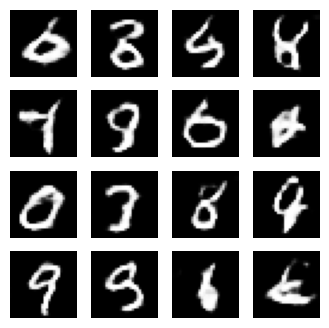

Epoch 61, Generator Loss: 0.9211, Discriminator Loss: 1.1774, Real Accuracy: 0.3538, Fake Accuracy: 0.9484
Epoch 62 complete
Epoch 63 complete
Epoch 64 complete
Epoch 65 complete
Epoch 66 complete
Epoch 67 complete
Epoch 68 complete
Epoch 69 complete
Epoch 70 complete


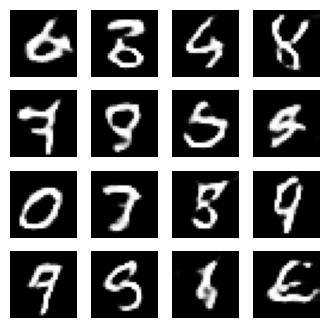

Epoch 71, Generator Loss: 0.9458, Discriminator Loss: 1.1705, Real Accuracy: 0.3755, Fake Accuracy: 0.9456
Epoch 72 complete
Epoch 73 complete
Epoch 74 complete
Epoch 75 complete
Epoch 76 complete
Epoch 77 complete
Epoch 78 complete
Epoch 79 complete
Epoch 80 complete


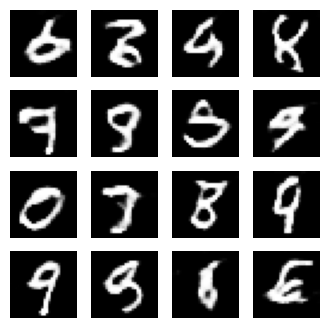

Epoch 81, Generator Loss: 1.0117, Discriminator Loss: 1.1461, Real Accuracy: 0.4403, Fake Accuracy: 0.9390
Epoch 82 complete
Epoch 83 complete
Epoch 84 complete
Epoch 85 complete
Epoch 86 complete
Epoch 87 complete
Epoch 88 complete
Epoch 89 complete
Epoch 90 complete


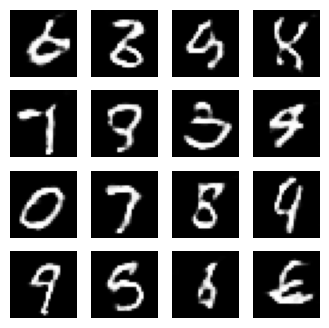

Epoch 91, Generator Loss: 0.9730, Discriminator Loss: 1.1587, Real Accuracy: 0.3771, Fake Accuracy: 0.9465
Epoch 92 complete
Epoch 93 complete
Epoch 94 complete
Epoch 95 complete
Epoch 96 complete
Epoch 97 complete
Epoch 98 complete
Epoch 99 complete
Epoch 100 complete


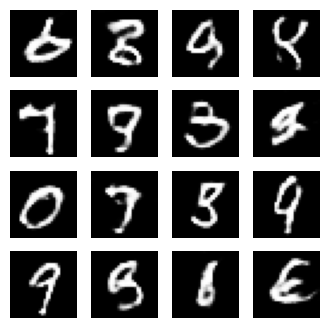

In [ ]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, 0.5), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, 0.5), tf.float32))
    return real_accuracy, fake_accuracy

def train(dataset, epochs):
    for epoch in range(epochs):
        gen_loss_epoch = 0
        disc_loss_epoch = 0
        real_acc_epoch = 0
        fake_acc_epoch = 0
        num_batches = 0

        for image_batch in dataset:
            train_step(image_batch)

            # Calculate losses and accuracies for metrics
            noise = tf.random.normal([BATCH_SIZE, noise_dim])
            generated_images = generator(noise, training=False)
            real_output = discriminator(image_batch, training=False)
            fake_output = discriminator(generated_images, training=False)
            gen_loss_epoch += generator_loss(fake_output)
            disc_loss_epoch += discriminator_loss(real_output, fake_output)
            real_acc, fake_acc = discriminator_accuracy(real_output, fake_output)
            real_acc_epoch += real_acc
            fake_acc_epoch += fake_acc
            num_batches += 1

        # Visualize the progress
        if epoch % 10 == 0:
            generate_and_save_images(generator, epoch, seed)

            # Calculate and print average losses and accuracies
            gen_loss_avg = gen_loss_epoch / num_batches
            disc_loss_avg = disc_loss_epoch / num_batches
            real_acc_avg = real_acc_epoch / num_batches
            fake_acc_avg = fake_acc_epoch / num_batches
            print(f"Epoch {epoch + 1}, Generator Loss: {gen_loss_avg:.4f}, Discriminator Loss: {disc_loss_avg:.4f}, Real Accuracy: {real_acc_avg:.4f}, Fake Accuracy: {fake_acc_avg:.4f}")

        else:
            print('Epoch {} complete'.format(epoch + 1))

    # Generate a final image and save it
    generate_and_save_images(generator, epochs, seed)

train(train_dataset, EPOCHS)

In [ ]:
# # Train the GAN
# def train(dataset, epochs):
#     for epoch in range(epochs):
#         for batch in dataset:
#             train_step(batch)

#         # Display generated images every 10 epochs
#         if (epoch + 1) % 10 == 0:
#             generate_and_save_images(generator, epoch + 1, seed)

In [ ]:
# # Generate and save images
# def generate_and_save_images(model, epoch, test_input):
#     # Generate images from model
#     predictions = model(test_input, training=False)

#     # Rescale pixel values from [-1, 1] to [0, 1]
#     predictions = (predictions + 1) / 2.0

#     # Create figure and subplot
#     fig = plt.figure(figsize=(4, 4))
#     for i in range(predictions.shape[0]):
#         plt.subplot(4, 4, i+1)
#         plt.imshow(predictions[i, :, :, 0], cmap='gray')
#         plt.axis('off')

#     # Save generated images
#     plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
#     plt.show()